## Logistic Regression

Here, we will demonstrate the algorithm we use for building a binary classification model, Logistic Regression. We will run through the calculations on a small example in order to demonstrate how to algorithm works. We also discuss some of the areas where this algorithm can be parallelized for efficiency.

### Theory

Logistic regression is a method for binary classification that models the log odds of success (link function) outcome as a function of a linear prediction. At inference time, given a set of weights for each feature, the probability of success can therefore be calculated from the logistic function.

$$
\log (\frac{\pi}{1-\pi}) = \beta_0 + \beta_1 * x_1+...
$$

$$
\pi = \frac{1}{1-e^{\beta_0 + \beta_1 * x_1+...}}
$$

In order to train our classifier, we employ binary crossentropy, or log maximum likelihood, as our loss function, and perform gradient based updates in order to generate update steps. The loss is written as (with y_i hat as the predicted probability of success, taking convention that log(0) = 0). We also add L2 regularization. The three components are: loss if example is positive plus loss if example is negative plus regularization term:

$$
L = 
$$

$$
\sum_i y_i * \log(\hat y_i) +
$$

$$
(1-y_i) * \log(1 - \hat y_i) + 
$$

$$
\lambda \sum_i \beta_i^2
$$

To update parameters in gradient descent, the gradient of the loss with respect to each parameter is calculated. The gradient update rule for the vector beta is (with alpha as the learning rate):

$$
\beta_t = \beta_{t-1} - \alpha * \sum_i (y_i - \hat y_i) x_i - \lambda \beta
$$

Since the loss is a sum over the individual examples in the training set, this process can be easily parallelized and distributed across different nodes of a cluster. We then have a reducer that combines the results of each node, and add them together to get the final loss. We can also add a weight to each example, which would be reflected as another coefficient in the summation for each example (not shown here).

To give an example, we'll use numpy to perform the calculations of one gradient step, and an example of inference, with an example with 2 data points and 2 features.

In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [0]:
#initialize 2x2 for 2 examples and two features. Extra column of 1 to make calculation of beta_0 easier

data = [[1, 0.5, 0.9],
        [1, 0.7, 0.1]]

#First example is negative, second is positive
Y = [0,1]

#Initialize weights for beta_0, 1 and 2
beta = np.random.random(3)

#### Inference

Given weights, we can calculate probability of each example being positive, and loss.

In [0]:
def logistic(linear_predictor):
  return 1/(1+np.exp(-1 * linear_predictor))
def probs(data, weights):
  linear = np.dot(data, weights)
  return list(logistic(linear))

p = probs(data, beta)
print ("Probability of success for two examples: %f, %f" %(p[0], p[1]))

Probability of success for two examples: 0.749135, 0.676180

#### Training

We now perform 20 gradient update steps and see that the probability of first example decreases, while the probability of second example increases (as it should based on the labels).

In [0]:
def gradient_update(data, Y, weights):
  predictions = probs(data, weights) - np.array(Y)
  return np.dot(predictions, data)
def update(data, Y, weights, alpha = 0.3, reg = 0.1):
  new_weights = weights - gradient_update(data, Y, weights) - reg * weights
  return new_weights

In [0]:
def train_logistic_regression(data, Y, weights, iterations = 50, alpha = 0.3, reg = 0.1):
  p1 = []
  p2 = []
  new_beta = weights
  
  for _ in range(iterations):
    new_beta = update(data, Y, new_beta, alpha, reg)
    p = probs(data, new_beta)
    p1.append(p[0])
    p2.append(p[1])
    
  return p1, p2

In [0]:
p1, p2 = train_logistic_regression(data, Y, beta)

Out[135]:

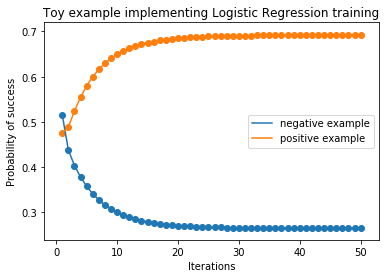

<matplotlib.legend.Legend at 0x7f1fbc1650d0>

In [0]:
plt.plot(range(1, len(p1) + 1), p1, label = 'negative example')
plt.scatter(range(1, len(p1) + 1), p1)

plt.plot(range(1, len(p1) + 1), p2, label = 'positive example')
plt.scatter(range(1, len(p1) + 1), p2)

plt.xlabel ("Iterations")
plt.ylabel("Probability of success")
plt.title("Toy example implementing Logistic Regression training")
plt.legend()

## Implementation in PyTorch of Logistic Regression

In [0]:
# generate random data
np.random.seed(123)
features = np.random.uniform(0, 1, size=(100, 2))
target = np.random.randint(2, size=100).reshape(100,)

In [0]:
# shuffle data
idx = np.arange(target.shape[0])
np.random.shuffle(idx)

# train, test
X_test, y_test = features[idx[:25]], target[idx[:25]]
X_train, y_train = features[idx[25:]], target[idx[25:]]

# normalize
mu, std = np.mean(X_train, axis=0), np.std(X_train, axis=0)
X_train, X_test = (X_train - mu) / std, (X_test - mu) / std

In [0]:
# set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  
# manual logistic regression
class LogisticRegression():
    def __init__(self, num_features):
        self.num_features = num_features
        self.weights = torch.zeros(1, num_features, 
                                   dtype=torch.float32, device=device)
        self.bias = torch.zeros(1, dtype=torch.float32, device=device)

        # forward propagation
    def forward(self, x):
        linear = torch.add(torch.mm(x, self.weights.t()), self.bias).view(-1)
        probas = self._sigmoid(linear)
        return probas
      
        # backward propagation
    def backward(self, x, y, probas):  
        grad_loss_out = y - probas.view(-1)
        grad_loss_w = -torch.mm(x.t(), grad_loss_out.view(-1, 1)).t()
        grad_loss_b = -torch.sum(grad_loss_out)
        return grad_loss_w, grad_loss_b
      
        # activation function
    def _sigmoid(self, z):
        return 1. / (1. + torch.exp(-z))
    
        # loss function: binary cross entropy/negative log-likelihood
    def _logit_cost(self, y, proba):
        tmp1 = torch.mm(-y.view(1, -1), torch.log(proba.view(-1, 1)))
        tmp2 = torch.mm((1 - y).view(1, -1), torch.log(1 - proba.view(-1, 1)))
        return tmp1 - tmp2
    
    def train(self, x, y, num_epochs, learning_rate=0.01):
        epoch_cost = []
        global preds1
        preds1 = []
        global labels1
        labels1 = []
        for e in range(num_epochs):
            
            #### Compute outputs ####
            probas = self.forward(x)
            preds = torch.where(probas > 0.5, torch.tensor(1, device=device), torch.tensor(0, device=device)).view(-1)
            correct = preds.eq(y).sum().item()
            preds1.append(preds)
            labels1.append(y)
            
            #### Compute gradients ####
            grad_w, grad_b = self.backward(x, y, probas)

            #### Update weights ####
            self.weights -= learning_rate * grad_w
            self.bias -= learning_rate * grad_b
            
            #### Logging ####
            cost = self._logit_cost(y, self.forward(x)) / x.size(0)
            print('Epoch: %03d' % (e+1), end="")
            print(' | Train ACC: %.3f' % correct, end="")
            print(' | Cost: %.3f' % cost)
            epoch_cost.append(cost)
        return epoch_cost

In [0]:
# turn numpy to tensors
X_train_tensor = torch.as_tensor(X_train, dtype=torch.float32, device=device)
y_train_tensor = torch.as_tensor(y_train, dtype=torch.float32, device=device)

# instantiate the model
model = LogisticRegression(num_features=2)
# run the model
epoch_cost = model.train(X_train_tensor, y_train_tensor, num_epochs=15, learning_rate=0.1)

print('\nModel parameters:')
print('  Weights: %s' % model.weights)
print('  Bias: %s' % model.bias)

Epoch: 001 | Train ACC: 36.000 | Cost: 0.673
Epoch: 002 | Train ACC: 45.000 | Cost: 0.659
Epoch: 003 | Train ACC: 48.000 | Cost: 0.658
Epoch: 004 | Train ACC: 44.000 | Cost: 0.656
Epoch: 005 | Train ACC: 49.000 | Cost: 0.655
Epoch: 006 | Train ACC: 43.000 | Cost: 0.654
Epoch: 007 | Train ACC: 50.000 | Cost: 0.654
Epoch: 008 | Train ACC: 44.000 | Cost: 0.653
Epoch: 009 | Train ACC: 49.000 | Cost: 0.653
Epoch: 010 | Train ACC: 45.000 | Cost: 0.653
Epoch: 011 | Train ACC: 48.000 | Cost: 0.652
Epoch: 012 | Train ACC: 46.000 | Cost: 0.652
Epoch: 013 | Train ACC: 47.000 | Cost: 0.652
Epoch: 014 | Train ACC: 45.000 | Cost: 0.652
Epoch: 015 | Train ACC: 47.000 | Cost: 0.652

Model parameters:
 Weights: tensor([[0.6592, 0.0226]])
 Bias: tensor([0.0775])

In [0]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, matthews_corrcoef

In [0]:
f1_score(torch.cat(preds1), torch.cat(labels1), average='weighted')

Out[54]: 0.6099085136508191